In [5]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import math

Status {'size': 75, 'color': 'bisque'}
Rewards {'size': 75, 'color': 'bisque'}
Returns {'size': 75, 'color': 'bisque'}
Listens {'size': 75, 'color': 'lightblue'}
Understands {'size': 75, 'color': 'lightblue'}
Encourages {'size': 75, 'color': 'lightblue'}
Autonomy {'size': 75, 'color': 'thistle'}
Belonging {'size': 75, 'color': 'thistle'}
Competence {'size': 75, 'color': 'thistle'}
Frustrated {'size': 75, 'color': 'pink'}
Drained {'size': 75, 'color': 'pink'}
Strong {'size': 75, 'color': 'pink'}
Meaning {'size': 75, 'color': 'palegreen'}
Ideas {'size': 75, 'color': 'palegreen'}
Values {'size': 75, 'color': 'palegreen'}
Stay {'size': 75, 'color': 'palegreen'}
Satisfied {'size': 75, 'color': 'palegreen'}


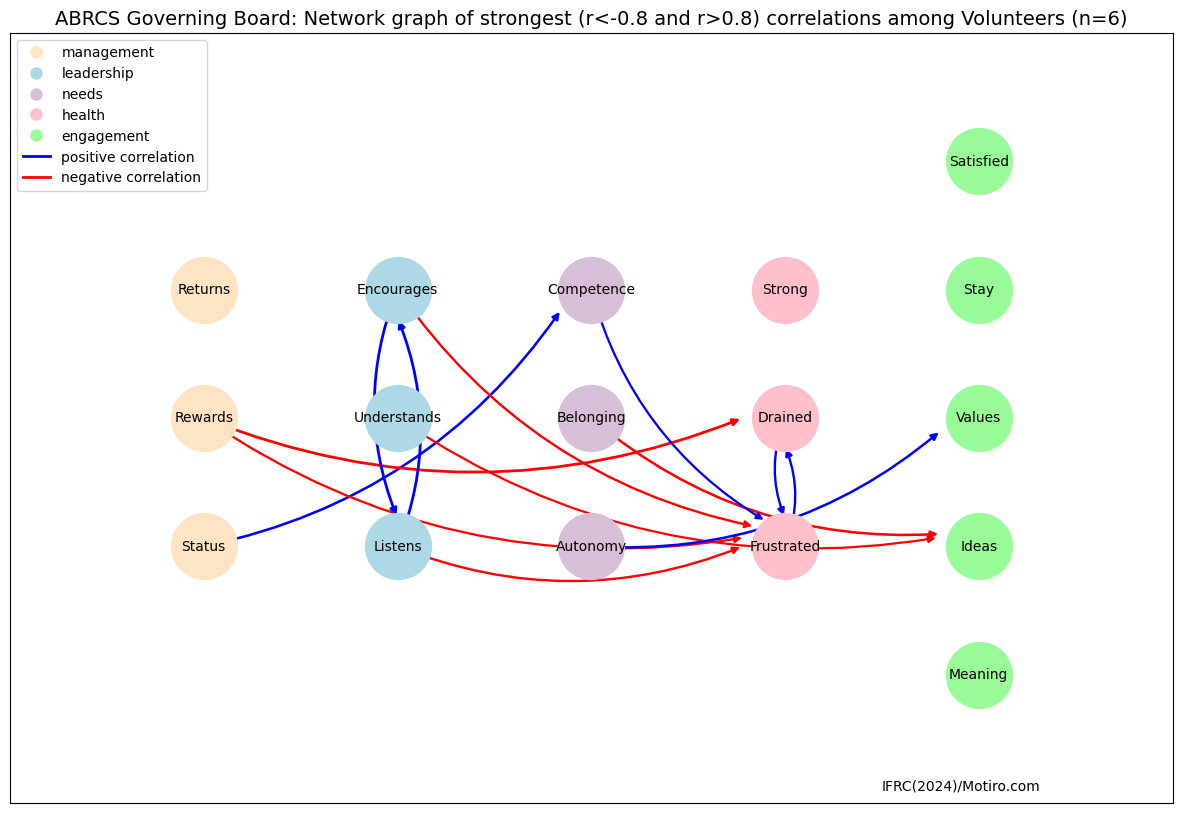

In [15]:
## Provides a network graph where nodes are key Motiro/SDT indicators
# and edges represent correlations between them.
## select strength of correlations to be displayed,
# knowing that the correlation coefficient ranges from -1 to 1
# and that the strength of the correlation is considered to be weak
# if its absolute value is less than 0.5.

# Load the dataset
file_path = "Individual.csv"
df = pd.read_csv(file_path, sep=",", encoding='utf-8')

## select which team to display
Team='ABRCS Governing Board'

# Filter the dataframe for 'Team Name'
df = df[df['Team Name'] == Team]

#For circles (groups of teams), further filtering might be required:
#df = df[df['Position'] == 'Staff']
#df = df[df['frontline'] == 'Frontline']
#df = df[df['region'] == 'Donetsk Region']

#set correlation coefficient thresholds for graph
negcorr = -0.8
poscorr = 0.8

# Count the total number of respondents in filtered dataframe (n)
n = df['Volunteer'].sum() + df['Staff'].sum()

# Compute correlation matrix with numeric_only set to True to avoid warning
corr_matrix = df.corr(numeric_only=True)


# Define variable sets
management_vars = ['Status', 'Rewards', 'Returns']
leadership_vars = ['Listens', 'Understands', 'Encourages']
needs_vars = ['Autonomy', 'Belonging', 'Competence']
health_vars = ['Frustrated', 'Drained', 'Strong']
engagement_vars = ['Meaning', 'Ideas', 'Values', 'Stay', 'Satisfied']

all_vars = management_vars + leadership_vars + needs_vars + health_vars + engagement_vars

# Create the graph
G = nx.DiGraph()

# Define variable colors
colors = {
    'management_vars': 'bisque',
    'leadership_vars': 'lightblue',
    'needs_vars': 'thistle',
    'health_vars': 'pink',
    'engagement_vars': 'palegreen'
}

# Modify the node addition part to include the color attribute
for var in all_vars:
    node_size = sum(corr_matrix[var])  # Sum of correlation coefficients
    if var in management_vars:
        node_color = colors['management_vars']
    elif var in leadership_vars:
        node_color = colors['leadership_vars']
    elif var in needs_vars:
        node_color = colors['needs_vars']
    elif var in health_vars:
        node_color = colors['health_vars']
    else:
        node_color = colors['engagement_vars']
    G.add_node(var, size=node_size, color=node_color)
    

# adjust arrows so that they touch circle periphery and are not hidden by the nodes' colored circle

def adjust_line_to_circle(x1, y1, x2, y2, r):
    """
    Adjusts the line segment (x1, y1) to (x2, y2) to stop at the circumference of a circle of radius r centered at (x2, y2).
    """
    angle = math.atan2(y2 - y1, x2 - x1)
    x2_new = x2 - r * math.cos(angle)
    y2_new = y2 - r * math.sin(angle)
    return x1, y1, x2_new, y2_new

# Add edges with color and weight attributes
for var1 in all_vars:
    for var2 in all_vars:
        correlation = corr_matrix[var1][var2]
        if var1 != var2 and not np.isnan(correlation) and (correlation > poscorr or correlation < negcorr):
            weight = abs(correlation)
            color = 'blue' if correlation > 0 else 'red'
            
            # Define the direction based on variable sets
            if var1 in management_vars and (var2 in needs_vars or var2 in health_vars or var2 in engagement_vars):
                G.add_edge(var1, var2, weight=weight, color=color)
            elif var1 in leadership_vars and (var2 in needs_vars or var2 in health_vars or var2 in engagement_vars):
                G.add_edge(var1, var2, weight=weight, color=color)
            elif var1 in needs_vars and (var2 in health_vars or var2 in engagement_vars):
                G.add_edge(var1, var2, weight=weight, color=color)
            elif var1 in management_vars and (var2 in health_vars or var2 in engagement_vars):
                G.add_edge(var1, var2, weight=weight, color=color)
            elif var1 in leadership_vars and (var2 in health_vars or var2 in engagement_vars):
                G.add_edge(var1, var2, weight=weight, color=color)
            elif var1 in health_vars and var2 in engagement_vars:
                G.add_edge(var1, var2, weight=weight, color=color)
            elif set([var1, var2]).issubset(set(management_vars)) or \
                 set([var1, var2]).issubset(set(leadership_vars)) or \
                 set([var1, var2]).issubset(set(needs_vars)) or \
                 set([var1, var2]).issubset(set(health_vars)) or \
                 set([var1, var2]).issubset(set(engagement_vars)):
                # Only add bidirectional arrows if they're in the same set
                G.add_edge(var1, var2, weight=weight, color=color)
                G.add_edge(var2, var1, weight=weight, color=color)

# Create positions for nodes
positions = {}
spacing_h = 1
spacing_v = 1

# Compute maximum group length for vertical centering
max_len = max(map(len, [management_vars, leadership_vars, needs_vars, health_vars, engagement_vars]))

for i, group in enumerate([management_vars, leadership_vars, needs_vars, health_vars, engagement_vars]):
    # Compute the starting y-coordinate for this group
    start_y = (max_len - len(group)) * spacing_v / 2
    
    for j, var in enumerate(group):
        positions[var] = (i * spacing_h, start_y + j * spacing_v)

for node, attributes in G.nodes(data=True):
    if np.isnan(attributes['size']):
        G.nodes[node]['size'] = 75  # Set default size

for node, data in G.nodes(data=True):
    print(node, data)

# Dummy lines for the legend
from matplotlib.lines import Line2D
legend_elements = []

# Adding legend for nodes
for label, color in colors.items():
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=label.replace('_vars', ''), markersize=10, markerfacecolor=color))

# Adding legend for edges
legend_elements.append(Line2D([0], [0], color='blue', lw=2, label='positive correlation'))
legend_elements.append(Line2D([0], [0], color='red', lw=2, label='negative correlation'))

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

# Modify the Draw nodes part to use the color from the node attributes
for node, (x, y) in positions.items():
    node_color = G.nodes[node]['color']
    ax.scatter(x, y, s=G.nodes[node]['size'] * 30, c=node_color, zorder=2)
    ax.text(x, y, node, ha='center', va='center', fontsize=10, zorder=3)

# Draw edges with a slight curve using connectionstyle
for u, v, data in G.edges(data=True):
    x1, y1 = positions[u]
    x2, y2 = positions[v]
    
    # Adjust end of arrow to connect to the node circle's periphery
    node_radius = math.sqrt(G.nodes[v]['size'] * 0.002 / math.pi)
    x1, y1, x2, y2 = adjust_line_to_circle(x1, y1, x2, y2, node_radius)

    arrowprops = dict(arrowstyle='-|>', linewidth=data['weight'] * 2, color=data['color'], 
                      connectionstyle="arc3,rad=0.2")  # Adding a curve
    plt.annotate("", xy=(x2, y2), xytext=(x1, y1), arrowprops=arrowprops, zorder=1)

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper left')

Position = ', '.join(df['Position'].unique())
plt.title(f'{Team}: Network graph of strongest (r<{negcorr} and r>{poscorr}) correlations among {Position}s (n={n})', size=14)
plt.text(3.5, -0.9, "IFRC(2024)/Motiro.com", size=10)
plt.xlim(-1, len([management_vars, leadership_vars, needs_vars, health_vars, engagement_vars]))
plt.ylim(-1, max_len)  # Using max_len for the ylim

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(f'{Team} SDTCorrNetworkGraph.png', bbox_inches='tight', pad_inches=0.1)
plt.show()
